In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker

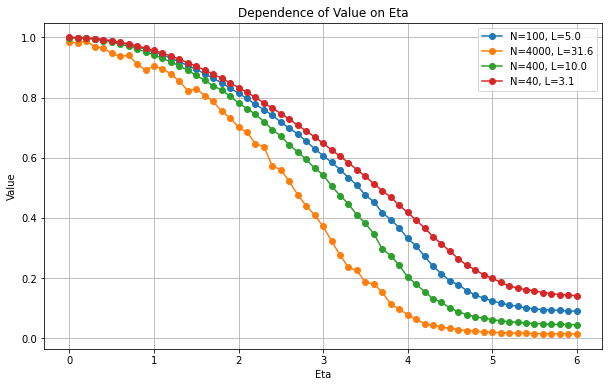

In [2]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Pobranie listy plików w bieżącym katalogu
folder_path = "./results_plot1"  # Możesz zmienić ścieżkę na odpowiednią
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Słownik do przechowywania danych
data = {}

pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

for file in files:
    match = pattern.match(file)
    if match:
        #print(f"Matched: {file}")
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2
        
        value = np.load(os.path.join(folder_path, file))
        key = (N, L)
        if key not in data:
            data[key] = []
        data[key].append((eta, value))

# Rysowanie wykresów
def plot_data(data):
    va_eta = {}
    plt.figure(figsize=(10, 6))
    for (N, L), values in data.items():
        values.sort()  # Sortujemy po eta
        etas, results = zip(*values)
        plt.plot(etas, results, marker='o', label=f'N={N}, L={L}')
        va_eta[N] = results
    plt.xlabel('Eta')
    plt.ylabel('Value')
    plt.title('Dependence of Value on Eta')
    plt.legend()
    plt.grid()
    plt.show()
    return va_eta

va_eta = plot_data(data)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Znalezione pliki: ['va_mean_N1000_L20_eta2_00.npy', 'va_mean_N1040_L20_eta2_00.npy', 'va_mean_N1080_L20_eta2_00.npy', 'va_mean_N1120_L20_eta2_00.npy', 'va_mean_N1160_L20_eta2_00.npy', 'va_mean_N1200_L20_eta2_00.npy', 'va_mean_N120_L20_eta2_00.npy', 'va_mean_N1240_L20_eta2_00.npy', 'va_mean_N1280_L20_eta2_00.npy', 'va_mean_N1320_L20_eta2_00.npy', 'va_mean_N1360_L20_eta2_00.npy', 'va_mean_N1400_L20_eta2_00.npy', 'va_mean_N1440_L20_eta2_00.npy', 'va_mean_N1480_L20_eta2_00.npy', 'va_mean_N1520_L20_eta2_00.npy', 'va_mean_N1560_L20_eta2_00.npy', 'va_mean_N1600_L20_eta2_00.npy', 'va_mean_N160_L20_eta2_00.npy', 'va_mean_N1640_L20_eta2_00.npy', 'va_mean_N1680_L20_eta2_00.npy', 'va_mean_N1720_L20_eta2_00.npy', 'va_mean_N1760_L20_eta2_00.npy', 'va_mean_N1800_L20_eta2_00.npy', 'va_mean_N1840_L20_eta2_00.npy', 'va_mean_N1880_L20_eta2_00.npy', 'va_mean_N1920_L20_eta2_00.npy', 'va_mean_N1960_L20_eta2_00.npy', 'va_mean_N2000_L20_eta2_00.npy', 'va_mean_N200_L20_eta2_00.npy', 'va_mean_N2040_L20_eta2_00.

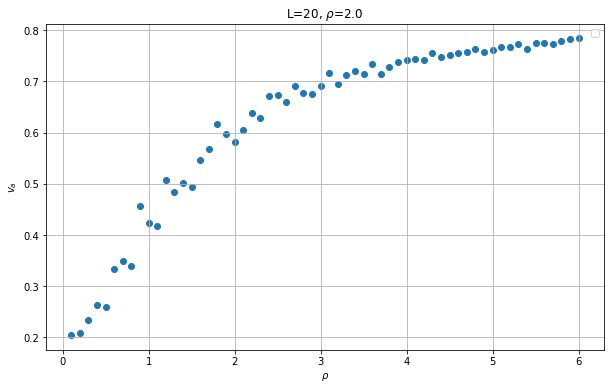

In [3]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Ścieżka do katalogu z plikami
folder_path = "results_plot2_rho_0_6_01"  # Zmień na właściwą ścieżkę

# Pobranie listy plików w katalogu
files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
print(f"Znalezione pliki: {files}")

# Słownik do przechowywania danych
data = {}

# Poprawione wyrażenie regularne dla nowego formatu
pattern = re.compile(r"va_mean_N(?P<N>\d+)_L(?P<L>[\d\.]+)_eta(?P<eta1>\d+)_(?P<eta2>\d+)\.npy")

# Lista do przechowywania danych
data_list = []

for file in files:
    match = pattern.match(file)
    if match:
        print(f"✅ Pasuje: {file}")  # Sprawdzenie, które pliki pasują
        N = int(match.group("N"))
        L = float(match.group("L"))
        eta = float(f"{match.group('eta1')}.{match.group('eta2')}")  # Łączenie eta1 i eta2

        value = np.load(os.path.join(folder_path, file))
        print(f"📥 Załadowano plik {file} z wartością {value}")

        data_list.append((N, L, eta, value))
    else:
        print(f"❌ Nie pasuje: {file}")

# Sortowanie listy po wartości N
data_list.sort(key=lambda x: x[0])

# Rysowanie wykresów
def plot_data(data_list):
    plt.figure(figsize=(10, 6))
    Ns, _, etas, values = zip(*data_list)
    
    plt.scatter(np.arange(0.1, 6.1, .1), values, marker='o')
    
    plt.xlabel('$\\rho$')
    plt.ylabel('$v_a$')
    plt.title('L=20, $\\rho$=2.0')
    plt.legend()
    plt.grid()
    plt.show()
    return values



values = plot_data(data_list)


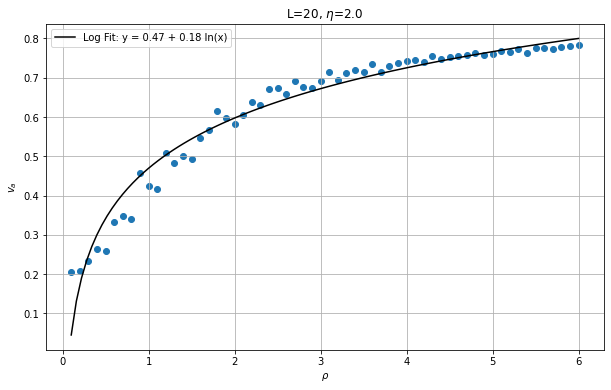

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data (replace this with your actual data)
x_data = np.arange(0.1, 6.1, .1)
y_data = values

# Define logarithmic function
def log_func(x, a, b):
    return  a + b * np.log(x)
# def log_func(x, b):
#     return b * np.log(x)
# Fit the curve
params, covariance = curve_fit(log_func, x_data, y_data)

# Extract parameters
a_fit, b_fit = params
# b_fit = params[0]
# Generate fitted values
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = log_func(x_fit, a_fit, b_fit)
# y_fit = log_func(x_fit, b_fit)


plt.figure(figsize=(10, 6))
plt.scatter( np.arange(0.1, 6.1, .1), values)
plt.plot(x_fit, y_fit, label=f"Log Fit: y = {a_fit:.2f} + {b_fit:.2f} ln(x)", color='k')
# plt.plot(x_fit, y_fit, label=f"Log Fit: y = {b_fit:.2f} ln(x)", color='k')
plt.xlabel('$\\rho$')
plt.ylabel('$v_a$')
plt.title('L=20, $\\eta$=2.0')
plt.legend()
plt.grid()
plt.show()


In [6]:
for k in va_eta.keys():
    va_eta[k] = np.array(va_eta[k])

Szacowane eta_c(L): {40: 3.6600384290513315, 100: 3.426527592236595, 400: 3.1220879926328253, 4000: 2.6622089504708946}
Szacowane rho_c(L=20): 0.9493556321855967
L=40: slope (beta) ~ 0.207
L=100: slope (beta) ~ 0.184
L=400: slope (beta) ~ 0.179
L=4000: slope (beta) ~ 0.200


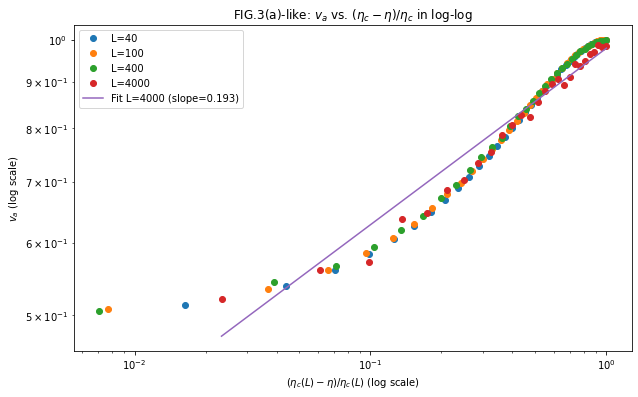

rho slope (delta) ~ 0.163


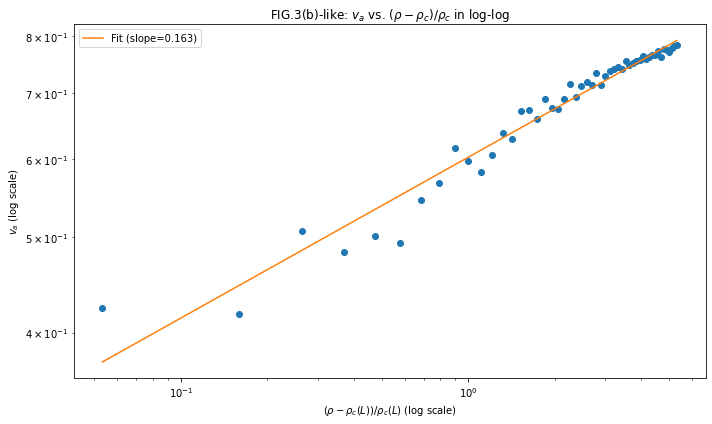

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import log

##############################
# 1) PRZYKŁAD DANYCH (fikcyjne!)
##############################

# Załóżmy, że z poprzednich symulacji masz tablice:
# v_a(eta) dla różnych L (przy stałej gęstości ρ=4),
#   -> eta_values_all[L] : tablica et
#   -> va_eta_all[L]     : tablica v_a(eta)
# oraz v_a(rho) dla L=20, eta=2
#   -> rho_values : tablica rho
#   -> va_rho     : tablica v_a(rho)
#
# Wstaw tutaj swoje realne wyniki; poniżej są "zastępniki"

eta_values_all = {
    40:  np.arange(0.0, 6.1, 0.1),
    100: np.arange(0.0, 6.1, 0.1),
    400: np.arange(0.0, 6.1, 0.1),
    4000: np.arange(0.0, 6.1, 0.1),
}
va_eta_all = va_eta

# Teraz dane v_a(rho) dla L=20, eta=2 (przykładowe, też fikcyjne):
rho_values = np.arange(0.1, 6.1, 0.1)
va_rho     = np.array(values)


##############################
# 2) WYZNACZANIE ETA_C(L) i RHO_C(L) - przykładowa metoda
##############################

def find_critical_via_halfmax(x_vals, va_vals):
    """
    Metoda 'połowy maksymalnej wartości'.
    Znajduje x_c, przy którym v_a spada do 0.5 * max(v_a).
    (Zakładamy, że v_a monotonicznie spada z rosnącym x.)
    """
    va_max = va_vals.max()
    half = 0.5 * va_max

    # sortujemy dane po x:
    idx_sort = np.argsort(x_vals)
    x_sorted = x_vals[idx_sort]
    va_sorted = va_vals[idx_sort]

    # tworzymy interpolację odwrotną: va -> x
    f = interp1d(va_sorted, x_sorted, kind='linear', bounds_error=False,
                 fill_value="extrapolate")

    x_c = float(f(half))
    return x_c

##############################
# 3) WYZNACZENIE ETA_C(L) i RHO_C(L)
##############################
eta_c_dict = {}
for L, etas in eta_values_all.items():
    va_vals = va_eta_all[L]
    # Tu jest fikcyjna metoda half-max:
    eta_c_est = find_critical_via_halfmax(etas, va_vals)
    eta_c_dict[L] = eta_c_est

# Przykład wyznaczenia rho_c(20)
rho_c_est = find_critical_via_halfmax(rho_values, va_rho)

print("Szacowane eta_c(L):", eta_c_dict)
print("Szacowane rho_c(L=20):", rho_c_est)

##############################
# 4) FIG.3(a): v_a vs ( (eta_c(L) - eta) / eta_c(L) ) w SKALI LOG-LOG
##############################
plt.figure(figsize=(10,6))
slopes_c = []
slopes_m = []
# plt.subplot(1,2,1)
for L, etas in eta_values_all.items():
    va_vals = va_eta_all[L]

    # 1) weź naszą "eta_c(L)"
    e_c = eta_c_dict[L]

    # 2) weź tylko te punkty, gdzie eta < eta_c(L) i v_a>0
    mask = (etas < e_c) & (va_vals>0)
    x_ = (e_c - etas[mask]) / e_c  # to jest (eta_c - eta)/eta_c
    y_ = va_vals[mask]

    # 3) odrzuć ewentualne <=0
    mask2 = (x_>0) & (y_>0)
    x_ = x_[mask2]
    y_ = y_[mask2]

    # 4) rysowanie w SKALI LOG-LOG
    #   -> zamiast plot(log(x), log(y)) i osi liniowych
    #   -> robimy po prostu:
    plt.loglog(x_, y_, 'o', label=f'L={L}')

    # 5) dopasowanie prostej w log-log
    #    log y = m * log x + c
    logx = np.log(x_)
    logy = np.log(y_)

    # aby "złapać" fragment, gdzie dane są ~liniowe, często ogranicza się do 
    # x_ bliskich 0 < x < 0.3 np. (to zależy)
    # Tu dla przykładu bierzemy je wszystkie.
    
    if len(logx) >= 2:
        A = np.vstack([logx, np.ones(len(logx))]).T
        m, c = np.linalg.lstsq(A, logy, rcond=None)[0]
        # m to slope ~ beta
        print(f"L={L}: slope (beta) ~ {m:.3f}")
        slopes_m.append(m)
        slopes_c.append(c)
c = np.mean(slopes_c)
m = np.mean(slopes_m)
x_fit = np.linspace(np.min(x_), np.max(x_), 100)
y_fit = np.exp(c) * x_fit**m
plt.loglog(x_fit, y_fit, '-', label=f'Fit L={L} (slope={m:.3f})')

plt.xlabel(r"$(\eta_c(L) - \eta)/\eta_c(L)$ (log scale)")
plt.ylabel(r"$v_a$ (log scale)")
plt.title("FIG.3(a)-like: $v_a$ vs. $(\eta_c - \eta)/\eta_c$ in log-log")
plt.legend()
# ax1 = plt.gca()
# ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
# ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y:.2f}"))

# plt.grid(True)
plt.show()
##############################
# 5) FIG.3(b): v_a vs ( (rho - rho_c(L)) / rho_c(L) ) w SKALI LOG-LOG
##############################
# plt.subplot(1,2,2)

plt.figure(figsize=(10,6))
rc = rho_c_est
# Mamy (rho_values, va_rho) -> z L=20, eta=2

maskr = (rho_values > rc) & (va_rho>0)
x_rho = (rho_values[maskr] - rc)/rc
y_rho = va_rho[maskr]

# Odrzucamy x<=0
maskr2 = (x_rho>0)
x_rho = x_rho[maskr2]
y_rho = y_rho[maskr2]

# rysujemy w skali log-log
plt.loglog(x_rho, y_rho, 'o')

# dopasowanie prostej
if len(x_rho)>=2:
    logx_rho = np.log(x_rho)
    logy_rho = np.log(y_rho)
    A2 = np.vstack([logx_rho, np.ones(len(logx_rho))]).T
    m2, c2 = np.linalg.lstsq(A2, logy_rho, rcond=None)[0]
    print(f"rho slope (delta) ~ {m2:.3f}")
    x_fit_rho = np.linspace(np.min(x_rho), np.max(x_rho), 100)
    y_fit_rho = np.exp(c2) * x_fit_rho**m2
    plt.loglog(x_fit_rho, y_fit_rho, '-', label=f'Fit (slope={m2:.3f})')

plt.xlabel(r"$(\rho - \rho_c(L))/\rho_c(L)$ (log scale)")
plt.ylabel(r"$v_a$ (log scale)")
plt.title("FIG.3(b)-like: $v_a$ vs. $(\\rho - \\rho_c)/\\rho_c$ in log-log")
# plt.grid(True)
plt.legend()
# ax2 = plt.gca()
# ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
# ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y:.2f}"))

plt.tight_layout()
plt.show()


The Vicsek model, introduced by Tamas Vicsek in 1995, is one of the fundamental models in the study of collision motion and collective behavior. The model simulates the motion of agents (particles) in a two-dimensional space, where each agent moves at a certain speed, adjusting its direction of motion based on the behavior of its neighbors. Vicesek's model is crucial in understanding such phenomena as the formation of swarms, flocks and other structures in nature.

**Parameters**
- N: Number of particles (agents).
- L: Size of the simulation space (L x L square).
- r: Neighborhood radius.
- eta $\eta$: Noise amplitude (range of random directional interference).
- v: Constant velocity.
- steps: Number of simulation time steps.
- dt: Time step length.
- store_trajectories: save positions after each step for simulation purposes.

In [63]:
result_50.shape

(1000, 100, 2)

In [12]:
import numpy as np
from scipy.spatial import cKDTree

def vicsek_simulation_ckdtree_vectorized(
    N=300, L=7.0, r=1.0, eta=0.2, v=0.03, 
    steps=500, dt=1.0, store_trajectories=True
):
    # --- Inicjalizacja ---
    positions = np.random.uniform(0, L, (N, 2))     # (N,2) położenia
    directions = np.random.uniform(0, 2*np.pi, N)   # (N,) kierunki w [0,2π)
    
    if store_trajectories:
        # Zapis w tablicach (steps+1) x N x 2 i (steps+1) x N
        # albo w listach - tutaj tablice:
        all_positions = np.empty((steps+1, N, 2), dtype=np.float32)
        all_directions = np.empty((steps+1, N), dtype=np.float32)
        all_positions[0] = positions
        all_directions[0] = directions
    else:
        all_positions = None
        all_directions = None
    
    # --- Główna pętla czasowa ---
    for step in range(steps):
        # 1) Budowa cKDTree (uwzględnia warunki periodyczne przez boxsize=L)
        tree = cKDTree(positions, boxsize=L)
        
        # 2) Lista list sąsiadów
        #    query_ball_point zwraca listę z N elementami; element i to lista sąsiadów i-tej cząstki
        neighbors_list = tree.query_ball_point(positions, r)
        
        # 2a) Opcjonalnie włączamy cząstkę samą w sobie (tak jak w oryginalnym Vicseku)
        for i, nbrs in enumerate(neighbors_list):
            if i not in nbrs:
                nbrs.append(i)
        
        # 2b) Określamy, ile maksymalnie sąsiadów występuje
        max_neighbors = max(len(nbrs) for nbrs in neighbors_list)
        
        # 2c) Tworzymy 2D tablicę o wymiarze (N, max_neighbors), wypełnioną -1
        neighbor_array = np.full((N, max_neighbors), -1, dtype=np.int32)
        
        # 2d) Wypełniamy neighbor_array indeksami sąsiadów
        for i, nbrs in enumerate(neighbors_list):
            neighbor_array[i, :len(nbrs)] = nbrs
        
        # 3) Wektorowo liczymy sumy sin i cos
        sin_dir = np.sin(directions)
        cos_dir = np.cos(directions)
        
        # Maska True/False = czy dany "slot" w neighbor_array jest obsadzony
        valid_mask = (neighbor_array != -1)  # shape (N, max_neighbors)
        
        # sin_dir[neighbor_array] - to shape (N, max_neighbors), ale -1 jest niepoprawnym indeksem.
        # Dlatego mnożymy przez valid_mask, by wyzerować wkład z -1.
        sum_sin = np.sum( sin_dir[neighbor_array] * valid_mask, axis=1 )
        sum_cos = np.sum( cos_dir[neighbor_array] * valid_mask, axis=1 )
        
        # Liczba sąsiadów
        count_neighbors = valid_mask.sum(axis=1)
        
        # Unikamy dzielenia przez zero (w modelu Vicseka z self in neighbors i tak count>=1)
        # Niemniej warto się zabezpieczyć:
        count_neighbors = np.where(count_neighbors==0, 1, count_neighbors)
        
        # Średnie sin i cos
        avg_sin = sum_sin / count_neighbors
        avg_cos = sum_cos / count_neighbors
        
        # Nowy kąt = arctan2(...) + noise
        # Noise w [-eta/2, +eta/2]
        noise = eta * (np.random.rand(N) - 0.5)
        
        new_directions = np.arctan2(avg_sin, avg_cos) + noise
        new_directions %= (2*np.pi)  # zawijamy w [0,2π)
        
        # 4) Aktualizacja położeń (wektorowo)
        positions[:,0] += v * np.cos(new_directions) * dt
        positions[:,1] += v * np.sin(new_directions) * dt
        positions %= L  # periodyczne warunki brzegowe
        
        # 5) Przepisujemy directions
        directions = new_directions
        
        # 6) Zapis do trajektorii, jeśli potrzebne
        if store_trajectories:
            all_positions[step+1] = positions
            all_directions[step+1] = directions
    
    return all_positions, all_directions


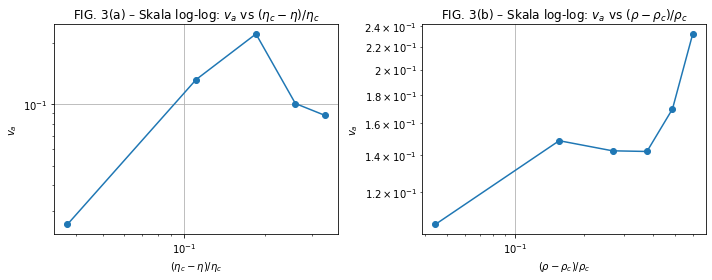

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import sqrt


def measure_order_parameter(positions, directions, v=0.03):
    """
    Zwraca v_a = (1/(N*v)) * || sum_i v_i ||,
    gdzie v_i to wektor prędkości cząstki i.
    positions - (N,2)
    directions - (N,) w radianach
    v - wartość prędkości każdej cząstki (skalar)
    """
    N = directions.shape[0]
    # Suma wektorów prędkości
    vx = np.cos(directions).sum()
    vy = np.sin(directions).sum()
    # Norma
    sum_norm = np.sqrt(vx*vx + vy*vy)
    return sum_norm / (N)

def measure_order_parameter_vectorized(all_directions):
    """
    Oblicza parametr porządku v_a dla każdego kroku czasowego.
    
    Parametry:
    - all_directions: tablica NumPy o kształcie (steps, N) zawierająca kierunki wszystkich cząstek
                      dla każdego kroku czasowego.
    
    Zwraca:
    - v_a: tablica NumPy o kształcie (steps,) zawierająca wartości parametru porządku dla każdego kroku.
    """
    # Obliczanie cos(i kierunku) i sin(i kierunku) dla wszystkich cząstek i kroków czasowych
    cos_dirs = np.cos(all_directions)  # Kształt: (steps, N)
    sin_dirs = np.sin(all_directions)  # Kształt: (steps, N)
    
    # Sumowanie po osi N (cząstki) dla każdego kroku czasowego
    sum_cos = np.sum(cos_dirs, axis=1)  # Kształt: (steps,)
    sum_sin = np.sum(sin_dirs, axis=1)  # Kształt: (steps,)
    
    # Obliczanie normy sum wektorowych
    sum_norm = np.sqrt(sum_cos**2 + sum_sin**2)  # Kształt: (steps,)
    
    # Obliczanie parametru porządku v_a
    v_a = sum_norm / all_directions.shape[1]  # Zakładamy, że all_directions.shape[1] = N
    
    return v_a

def run_and_get_va(N, L, r, eta, v, steps=500, warmup=200, repeats=1):
    """
    Uruchamia symulację modelu Vicseka, zwraca średni v_a
    (uśrednienie po 'repeats' realizacjach i po ostatnich krokach).
    - warmup określa liczbę kroków, po których zaczynamy uśrednianie.
    """
    va_list = []
    for _ in range(repeats):
        all_positions, all_directions = vicsek_simulation_ckdtree_vectorized(
            N=N, L=L, r=r, eta=eta, v=v, steps=steps, store_trajectories=True
        )

        all_directions_array = np.array(all_directions)  # Kształt: (steps, N)

# Obliczenie parametru porządku dla wszystkich kroków jednocześnie
        va_array = measure_order_parameter_vectorized(all_directions_array)

        # Obliczenie średniej wartości parametru porządku po wszystkich krokach
        va_mean = np.mean(va_array)
        va_list.append(va_mean)
    return np.mean(va_list)


def fig3_plots():
    """
    Przykład tworzenia wykresów analogicznych do FIG. 3 (a) i (b) w skali log-log,
    aby wyznaczyć wykładniki krytyczne beta, delta itp.
    Kod demonstruje koncepcję zbierania danych i rysowania
    w układzie [log - log], ale pomija pełną procedurę dopasowania eta_c, rho_c.
    """
    # Przykład: skanujemy eta w pobliżu pewnej 'zgadywanej' wartości krytycznej
    # i badamy v_a(eta). Załóżmy, że (na oko) eta_c ~ 1.5  -> to mocno przybliżone.
    # Zbieramy dane w okolicy 1.0 ... 2.0.
    eta_c_guess = 1.5
    etas = np.linspace(1.0, 2.0, 10)
    
    N=400
    L=sqrt(N/1.0)  # rho=1
    
    va_list = []
    for e in etas:
        va = run_and_get_va(N=N, L=L, r=1.0, eta=e, v=0.03, steps=30, warmup=20, repeats=1)
        va_list.append(va)
    
    # Przygotowujemy wartości x = (eta_c - eta)/eta_c
    x_vals = (eta_c_guess - etas) / eta_c_guess
    y_vals = va_list
    
    # Usuwamy ewentualne punkty ujemne (jeśli eta > eta_c)
    # bo w oryginalnej publikacji rysuje się to tylko tam, gdzie (eta_c - eta) > 0
    mask = x_vals > 0
    x_vals = x_vals[mask]
    y_vals = np.array(y_vals)[mask]
    
    # Rysowanie w skali log-log
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title("FIG. 3(a) – Skala log-log: $v_a$ vs $(\eta_c - \eta)/\eta_c$")
    plt.loglog(x_vals, y_vals, 'o-')
    plt.xlabel(r'$(\eta_c - \eta)/\eta_c$')
    plt.ylabel(r'$v_a$')
    plt.grid(True)
    
    # Analogicznie: "FIG. 3(b) – Skala log-log: $v_a$ vs $(\rho - \rho_c)/\rho_c$"
    # Przyjmijmy (dla przykładu) rho_c_guess = 0.5 i zmieniajmy rho ~ 0.3..0.8
    rho_c_guess = 0.5
    rhos = np.linspace(0.3, 0.8, 10)
    
    # Będziemy wykonywać symulacje z ustalonym eta < eta_c, np. 0.3
    va_rho_list = []
    for rh in rhos:
        L2 = sqrt(N/rh)
        va_rho = run_and_get_va(N=N, L=L2, r=1.0, eta=0.3, v=0.03, steps=30, warmup=2, repeats=1)
        va_rho_list.append(va_rho)
    
    x2_vals = (rhos - rho_c_guess) / rho_c_guess
    mask2 = x2_vals > 0
    x2_vals = x2_vals[mask2]
    y2_vals = np.array(va_rho_list)[mask2]
    
    plt.subplot(1,2,2)
    plt.title("FIG. 3(b) – Skala log-log: $v_a$ vs $(\\rho - \\rho_c)/\\rho_c$")
    plt.loglog(x2_vals, y2_vals, 'o-')
    plt.xlabel(r'$(\rho - \rho_c)/\rho_c$')
    plt.ylabel(r'$v_a$')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

fig3_plots()


In [14]:
def plot_fig1_scenarios():
    """
    Odtwarza scenariusze z Rys. 1 w artykule, gdzie:
      (a) t=0, L=7, eta=2.0
      (b) L=25, eta=0.1
      (c) L=7, eta=2.0 (po pewnym czasie)
      (d) L=5, eta=0.1 (wysoka gęstość, mały szum -> stan uporządkowany)
      
    Przyjmujemy N=300, v=0.03 w każdym przypadku.
    """
    # Parametry wspólne
    N = 300
    v = 0.03
    r = 1.0
    steps = 300  # liczba kroków (można zwiększyć, by efekt był silniejszy)
    
    # Konfiguracje (a), (b), (c), (d)
    configs = [
        dict(L=7,  eta=2.0, desc="(a) L=7, eta=2.0, t=0"),
        dict(L=25, eta=0.1, desc="(b) L=25, eta=0.1"),
        dict(L=7,  eta=2.0, desc="(c) L=7, eta=2.0"),
        dict(L=5,  eta=0.1, desc="(d) L=5, eta=0.1"),
    ]
    
    fig, axes = plt.subplots(2,2,figsize=(10,10))
    axes = axes.ravel()
    
    for i, cfg in enumerate(configs):
        # Uruchamiamy symulację
        # Uwaga: dla (a) chcemy widzieć TYLKO stan początkowy (t=0),
        #        w pozostałych - stan "po czasie".
        if i == 0:
            # "t=0" -> odpalamy, ale narysujemy tylko początek.
            all_pos, all_head = vicsek_simulation_ckdtree_vectorized(
                N=N, L=cfg['L'], r=r, eta=cfg['eta'], v=v, steps=1
            )
            step_to_plot = 0  # początek
        else:
            # (b), (c), (d) -> czekamy do końca
            all_pos, all_head = vicsek_simulation_ckdtree_vectorized(
                N=N, L=cfg['L'], r=r, eta=cfg['eta'], v=v, steps=steps
            )
            step_to_plot = -1  # ostatnia klatka
        
        ax = axes[i]
        
        # Ostatnie 20 kroków trajektorii (lub odpowiednio mniej, jeśli symulacja krótka)
        last_n = 20
        t_min = max(0, len(all_pos)-last_n)
        for t in range(t_min, len(all_pos)):
            pos_t = all_pos[t]
            ax.plot(pos_t[:,0], pos_t[:,1], 'k.', alpha=0.02)  # kropki trajektorii
        
        # Rysujemy strzałki
        pos_final = all_pos[step_to_plot]
        head_final = all_head[step_to_plot]
        ax.quiver(
            pos_final[:,0], pos_final[:,1],
            np.cos(head_final), np.sin(head_final),
            angles='xy', scale_units='xy', scale=1.0, color='blue'
        )
        
        ax.set_xlim([0, cfg['L']])
        ax.set_ylim([0, cfg['L']])
        ax.set_aspect('equal', 'box')
        ax.set_title(cfg['desc'])
    
    plt.suptitle("Rys. 1 – przykładowa wizualizacja modelu Vicseka (N=300, v=0.03)")
    plt.tight_layout()
    plt.show()

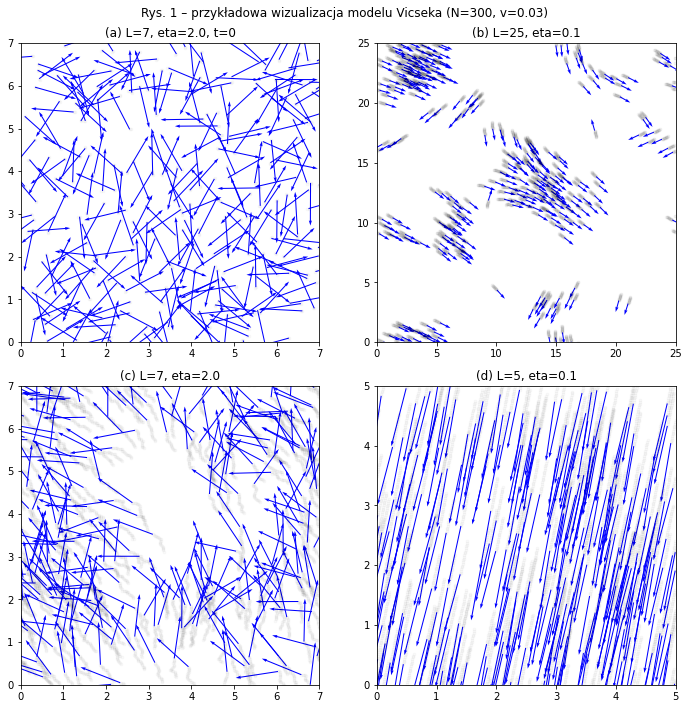

In [16]:
plot_fig1_scenarios()

---

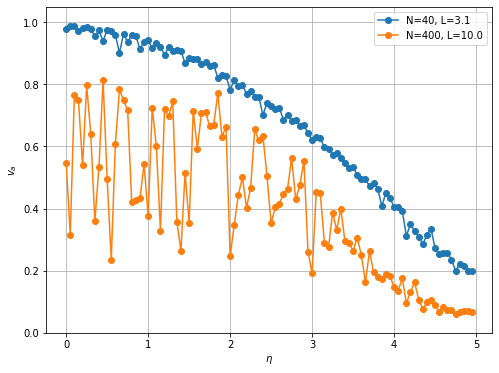

In [12]:
plot_fig2()